Generate a bone-scaling dataset

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn_test.routines.datasets import npy_keypts
from kpsn_test.routines.datasets import blscale
from kpsn_test.routines.util import update
from kpsn_test import visualize as viz
from kpsn.util import keypt_io

from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton

import numpy as np
import joblib as jl

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plot_dir = '../../plots/notebook/bonescale_dataset'

### Manually adjust

In [5]:
default_tree = skeleton.Armature(keypt_io.keypt_names, skeleton.bones, 'shldr')
hip_tree = skeleton.reroot(default_tree, 'hips')
# hip_tree = default_tree
skel = ls.construct_transform(hip_tree, hip_tree.keypt_by_name['hips'])

In [6]:
(N, M), gt_obs, metadata = npy_keypts.generate(
    cfg = update(npy_keypts.defaults, dict(
        path = '../../../data_explore/data',
        rescale = False,
        age_blacklist = [9, 12]
)))
slices = metadata['session_slice']

all_roots, all_bones = ls.transform(gt_obs.keypts.reshape([-1, 14, 3]), skel)
all_lengths = np.linalg.norm(all_bones, axis = -1)

ages, age_groups = keypt_io.get_groups_dict(metadata['age'])
sess_lengths = {
    sess_name: np.mean(all_lengths[slc], axis = 0)
    for sess_name, slc in slices.items()}
age_lengths = {
    age: np.mean([sess_lengths[s] for s in age_group], axis = 0)
    for age, age_group in zip(ages, age_groups)}

In [9]:
sess_lengths_by_age = {
    age: {s: sess_lengths[s] for s in age_group}
    for age, age_group in zip(ages, age_groups)
}
jl.dump(dict(mean = age_lengths, indiv = sess_lengths_by_age),
        '../../../data_explore/data/bl_scales.jl')

['../../../data_explore/data/bl_scales.jl']

In [7]:
remap_bones = {}
remap_metadata = {}
remap_lengths = {}
src_sessions = [age_groups[i][0] for i in [0]] # or [0, 1, 3, 5]

for src_sess in slices:
    slc = slices[src_sess]
    bones = {src_sess: all_bones[slc]}
    meta = {f'src-{k}': {src_sess: metadata[k][src_sess]} for k in metadata}
    src_age = metadata['age'][src_sess]
    meta['tgt_age'] = {src_sess: src_age}
    
    for tgt_age in ages:
        if tgt_age == src_age: pass

        new_sess = f'{tgt_age}wk_m{metadata["id"][src_sess]}'
        length_ratios = age_lengths[tgt_age] / age_lengths[src_age]
        bones[new_sess] = all_bones[slc] * length_ratios[None, :, None]
        for k in metadata:
            meta[f'src-{k}'][new_sess] = metadata[k][src_sess]
        meta['tgt_age'][new_sess] = tgt_age

    slcs, all_bn = keypt_io.to_flat_array(bones)
    remap_bones[src_sess] = all_bn
    remap_lengths[src_sess] = np.linalg.norm(all_bn, axis = -1)
    meta['session_slice'] = slcs
    remap_metadata[src_sess] = meta

### Load with routine

In [19]:
# initialize skeleton
default_tree = skeleton.default_armature
hip_tree = skeleton.reroot(default_tree, 'hips')
skel = ls.construct_transform(hip_tree, hip_tree.keypt_by_name['hips'])

# load unscaled poses and bone lengths
_, unscaled_obs, unscaled_meta = npy_keypts.generate(update(blscale.defaults, dict(
    path = '../../../data_explore/data',
    age_blacklist = [9, 12],
    rescale = True,
)))
all_roots, all_bones = ls.transform(unscaled_obs.keypts.reshape([-1, 14, 3]), skel)
all_lengths = np.linalg.norm(all_bones, axis = -1)
ages, age_groups = keypt_io.get_groups_dict(unscaled_meta['age'])
unscaled_slices = unscaled_meta['session_slice']


# src_sessions = [age_groups[i][0] for i in [0]] # or [0, 1, 3, 5]
src_sessions = ['3wk_m0']
remap_metadata = {}
remap_obs = {}
remap_lengths = {}
for src_sess in src_sessions:
    _, obs, meta = blscale.generate(update(blscale.defaults, dict(
        src_sess = src_sess,
        path = '../../../data_explore/data',
        age_blacklist = [9, 12],
        rescale = True,
    )))

    remap_obs[src_sess] = obs
    remap_metadata[src_sess] = meta
    remap_roots, remap_bones = ls.transform(
        obs.keypts.reshape([-1, hip_tree.n_kpts, 3]), skel)
    remap_lengths[src_sess] = np.linalg.norm(remap_bones, axis = -1)

### Validate results

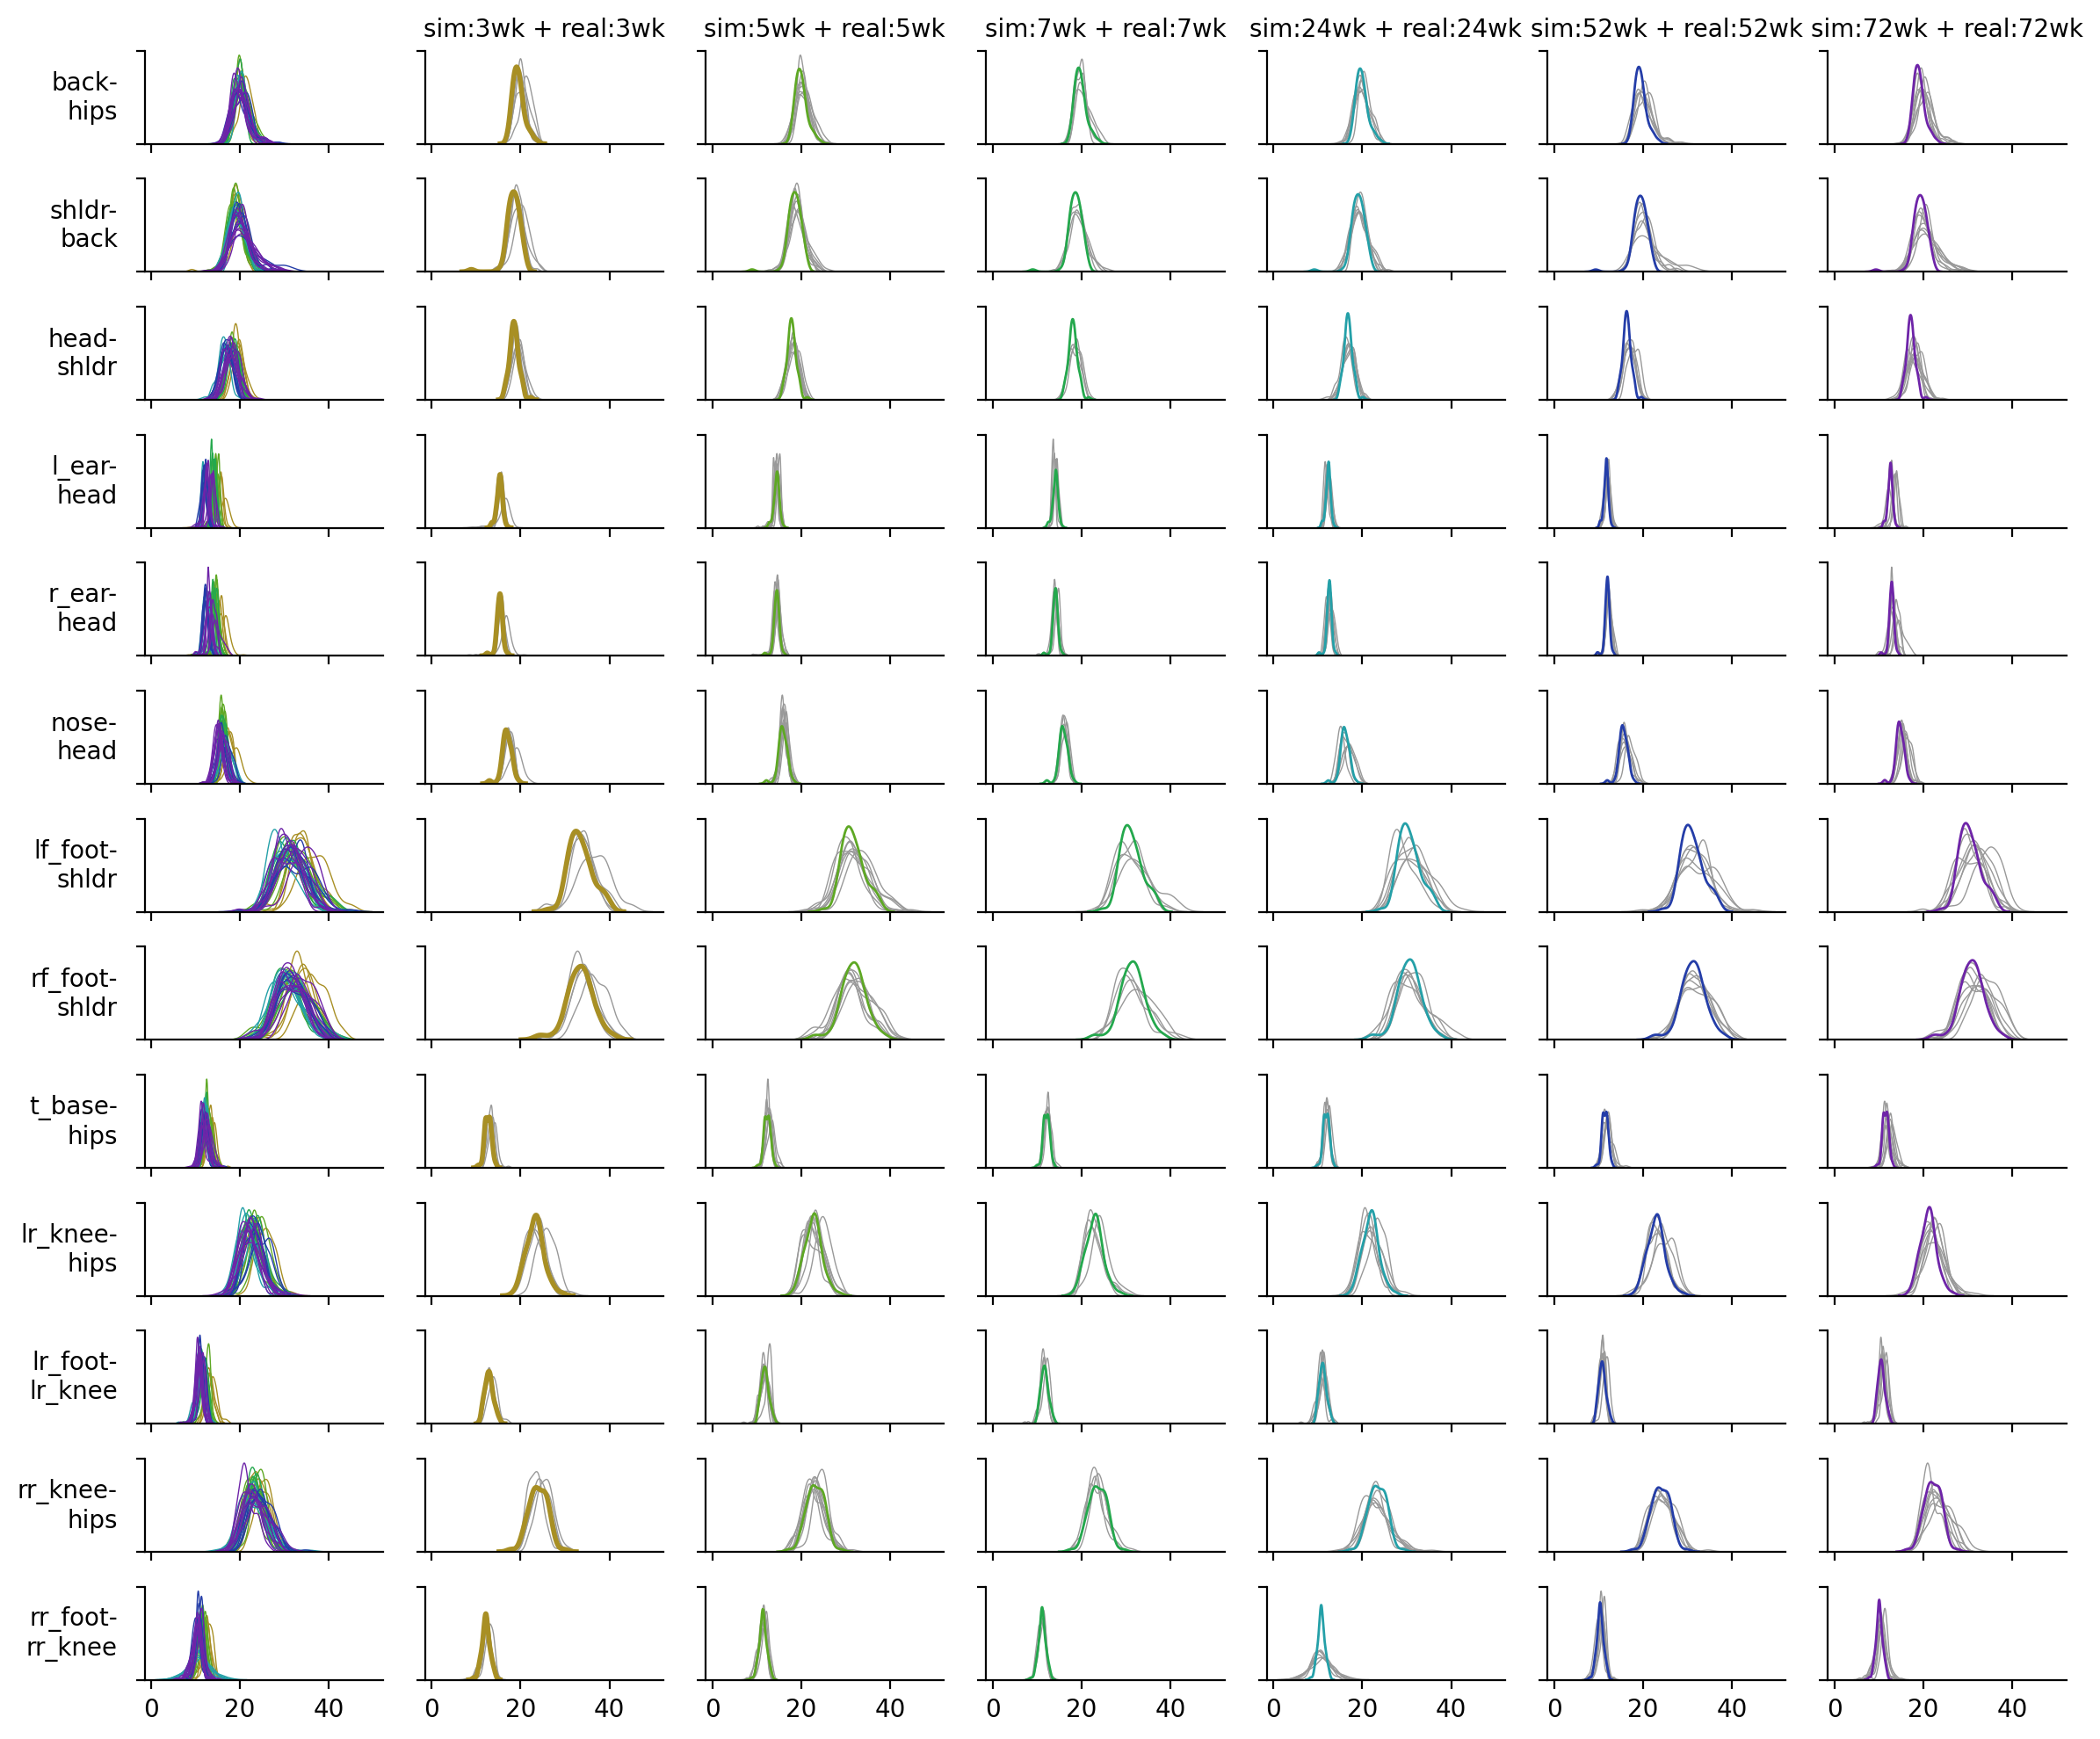

In [20]:
fig, ax = plt.subplots(figsize = (12, 10),
    nrows = all_bones.shape[-2],
    ncols = 1 + len(ages),
    sharex = True, sharey = 'row')
age_pal = viz.defaults.age_pal(unscaled_meta['age'])
src_sess = '3wk_m0'

subsample = 500
for i_bone in range(len(skeleton.bones)):
    for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
        for i_mouse, sess_name in enumerate(age_group):
            sns.kdeplot(
                all_lengths[unscaled_slices[sess_name]][::subsample, i_bone],
                ax = ax[i_bone, 0],
                color = age_pal[age],
                lw = 0.5,
                label = age if i_mouse == 0 else None)
            
            col = i_age + 1
            sns.kdeplot(
                all_lengths[unscaled_slices[sess_name]][::subsample, i_bone],
                ax = ax[i_bone, col],
                color = '.6',
                lw = 0.5,
                label = age if i_mouse == 0 else None)
    ax[i_bone, 0].set_ylabel(hip_tree.bone_name(i_bone, joiner = '-\n'),
            rotation = 0, verticalalignment = 'center',
            horizontalalignment = 'right')

    tgt_ages, tgt_age_groups = keypt_io.get_groups_dict(
        remap_metadata[src_sess]['tgt_age'])
    
    for i_tgt_age, (tgt_age, tgt_age_group) in enumerate(zip(tgt_ages, tgt_age_groups)):
        col = i_tgt_age + 1
        for i_tgt_sess, tgt_sess in enumerate(tgt_age_group):
            is_source = tgt_sess == src_sess
            slc = remap_metadata[src_sess]['session_slice'][tgt_sess]
            sns.kdeplot(
                    remap_lengths[src_sess][slc][::subsample, i_bone],
                    ax = ax[i_bone, col],
                    color = age_pal[tgt_age],
                    lw = 2 if is_source else 1,
                    # ls = '-' if is_source else '--',
                    label = tgt_age if i_tgt_sess == 0 else None)
        ax[0, col].set_title(f"sim:{tgt_age}wk + real:{tgt_age}wk", fontsize = 10)

for a in ax[:, 0]:
    a.set_yticks(a.get_ylim())
    a.set_yticklabels(["", ""])

sns.despine()
plt.tight_layout()
# plt.savefig(f"{plot_dir}/singlesubj-validation-scaled.png", dpi = 300)
plt.show()

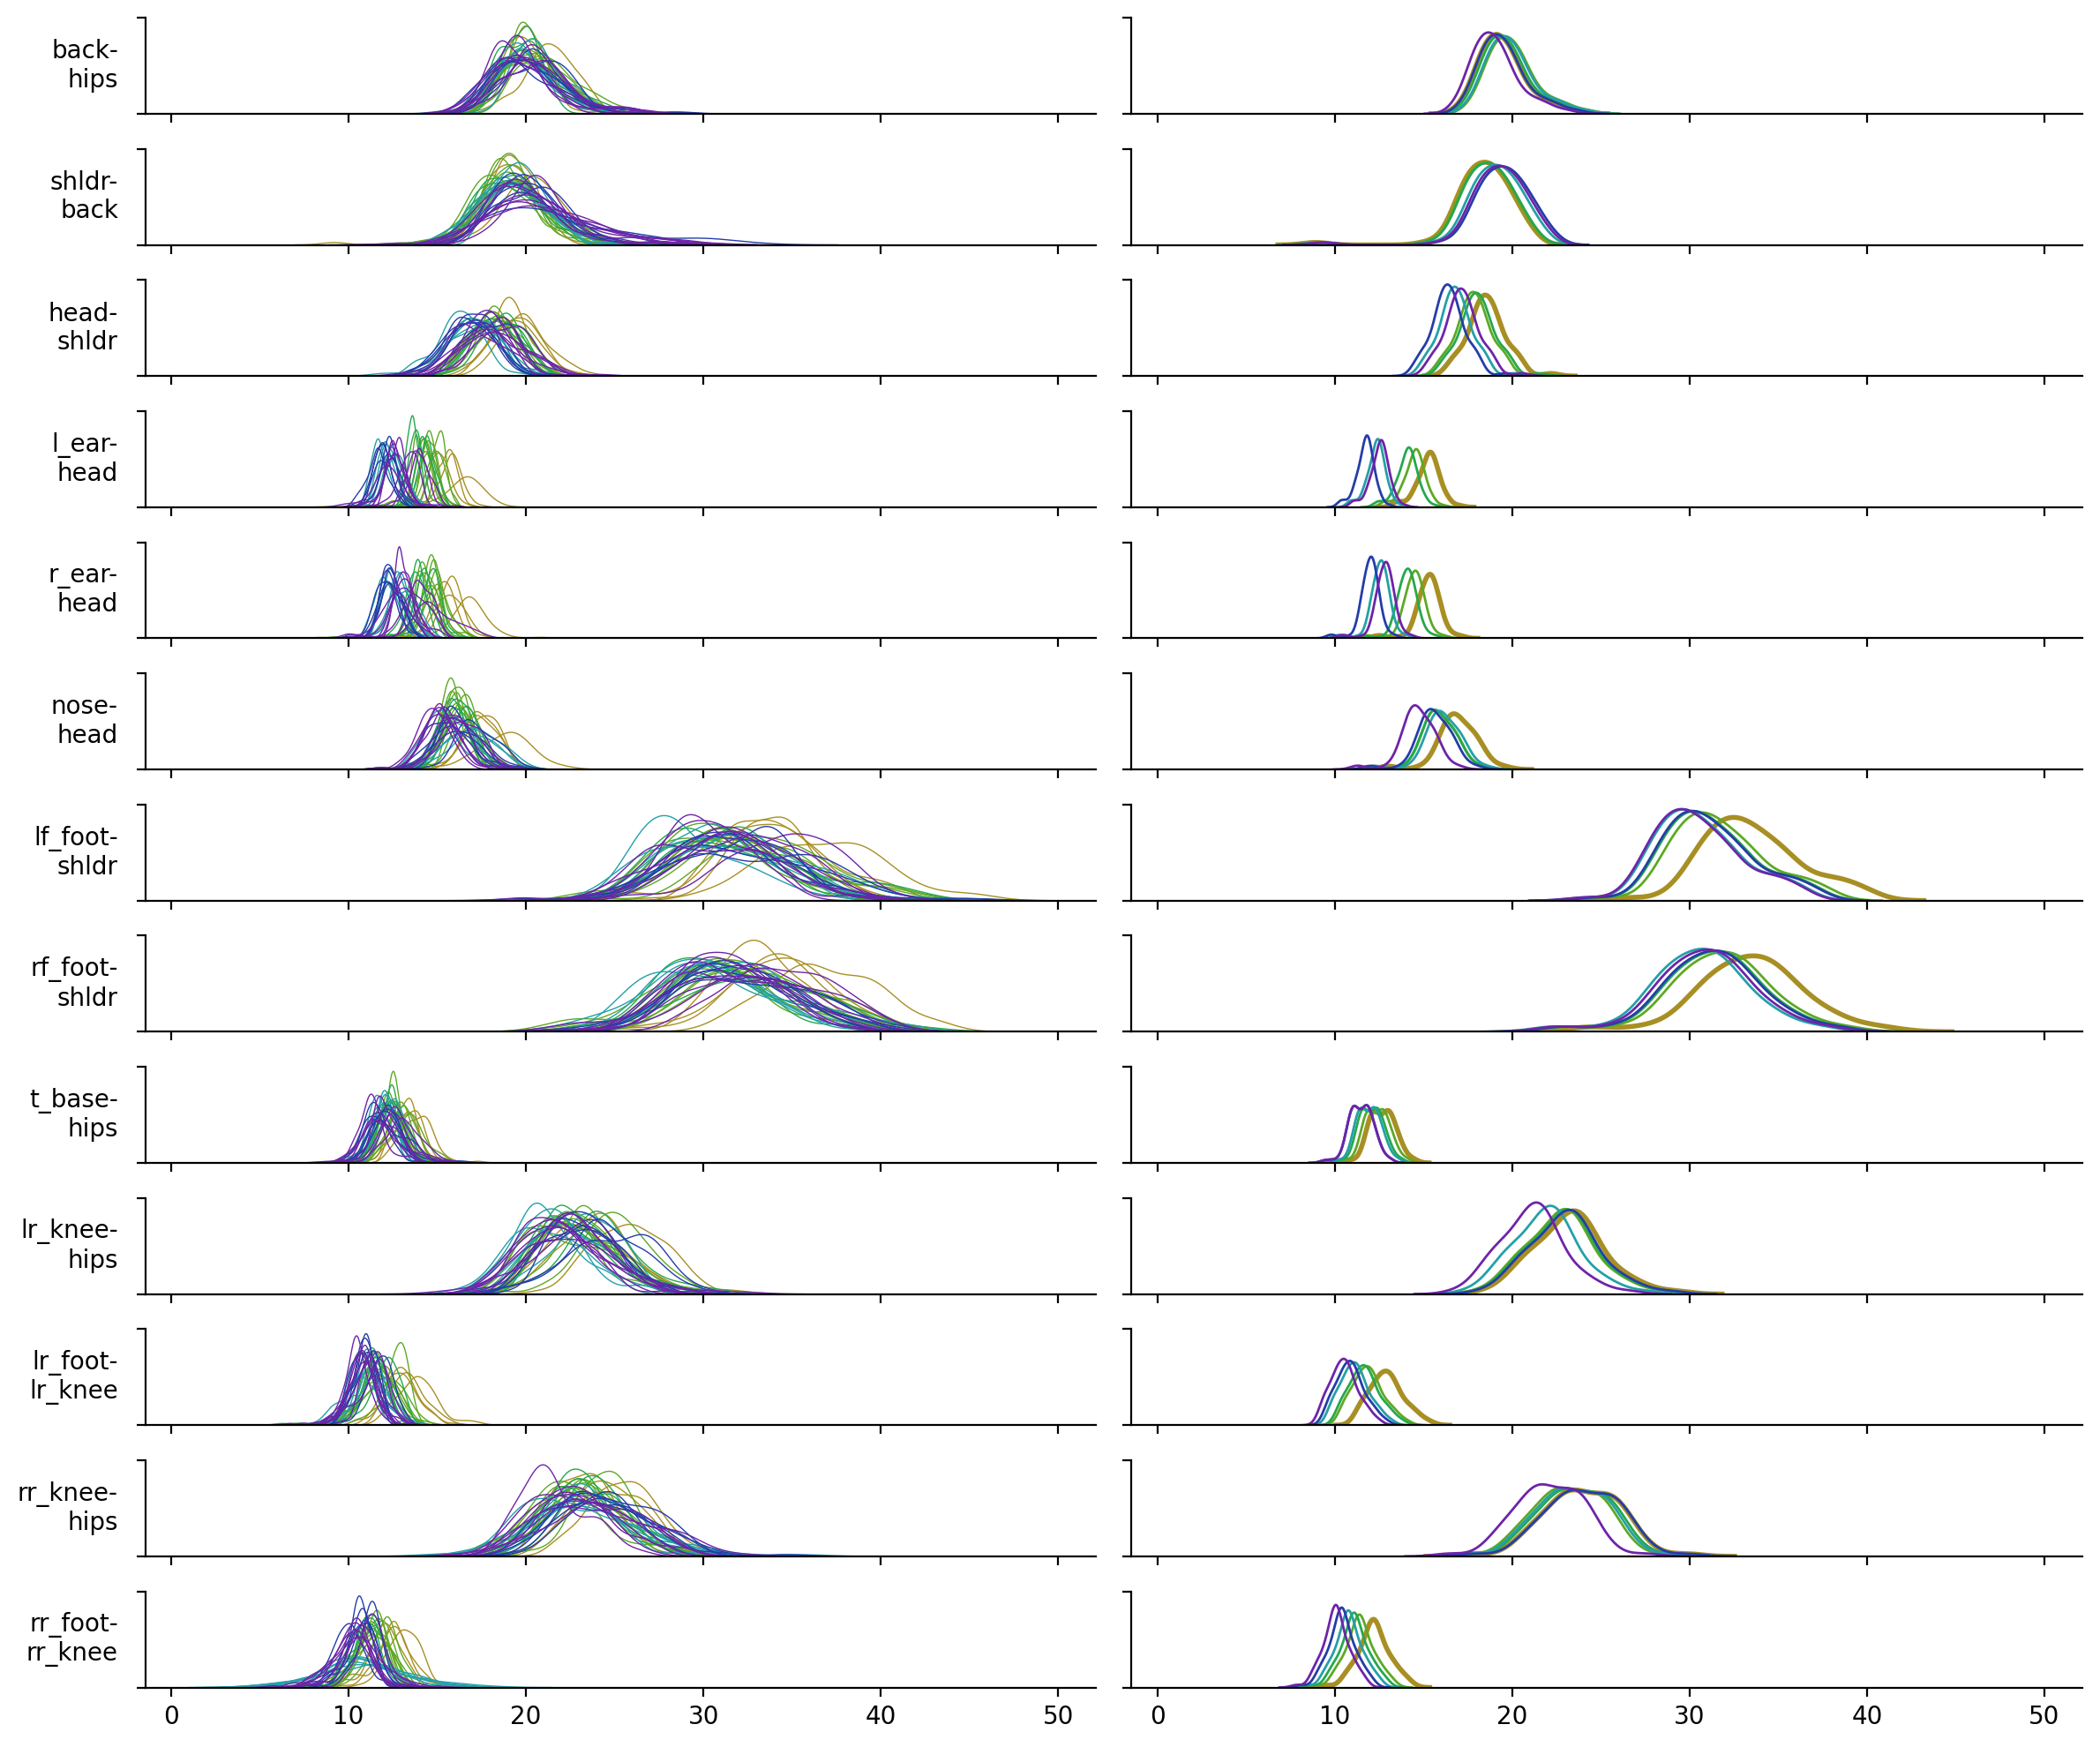

In [21]:
fig, ax = plt.subplots(figsize = (12, 10),
    nrows = all_bones.shape[-2],
    ncols = 2,
    sharex = True, sharey = 'row')
age_pal = viz.defaults.age_pal(unscaled_meta['age'])
src_sess = '3wk_m0'

subsample = 500
for i_bone in range(len(skeleton.bones)):
    for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
        for i_mouse, sess_name in enumerate(age_group):
            sns.kdeplot(
                all_lengths[unscaled_slices[sess_name]][::subsample, i_bone],
                ax = ax[i_bone, 0],
                color = age_pal[age],
                lw = 0.5,
                label = age if i_mouse == 0 else None)
            
            col = i_age + 1
            # sns.kdeplot(
            #     all_lengths[unscaled_slices[sess_name]][::subsample, i_bone],
            #     ax = ax[i_bone, col],
            #     color = '.6',
            #     lw = 0.5,
            #     label = age if i_mouse == 0 else None)
    ax[i_bone, 0].set_ylabel(hip_tree.bone_name(i_bone, joiner = '-\n'),
            rotation = 0, verticalalignment = 'center',
            horizontalalignment = 'right')

    tgt_ages, tgt_age_groups = keypt_io.get_groups_dict(
        remap_metadata[src_sess]['tgt_age'])
    
    for i_tgt_age, (tgt_age, tgt_age_group) in enumerate(zip(tgt_ages, tgt_age_groups)):
        for i_tgt_sess, tgt_sess in enumerate(tgt_age_group):
            is_source = tgt_sess == src_sess
            slc = remap_metadata[src_sess]['session_slice'][tgt_sess]
            sns.kdeplot(
                    remap_lengths[src_sess][slc][::subsample, i_bone],
                    ax = ax[i_bone, 1],
                    color = age_pal[tgt_age],
                    lw = 2 if is_source else 1,
                    # ls = '-' if is_source else '--',
                    label = tgt_age if i_tgt_sess == 0 else None)
        # ax[0, col].set_title(f"sim:{tgt_age}wk + real:{tgt_age}wk", fontsize = 10)

for a in ax[:, 0]:
    a.set_yticks(a.get_ylim())
    a.set_yticklabels(["", ""])

sns.despine()
plt.tight_layout()
plt.savefig(f"{plot_dir}/singlesubj-validation-scaled.png", dpi = 300)
plt.show()

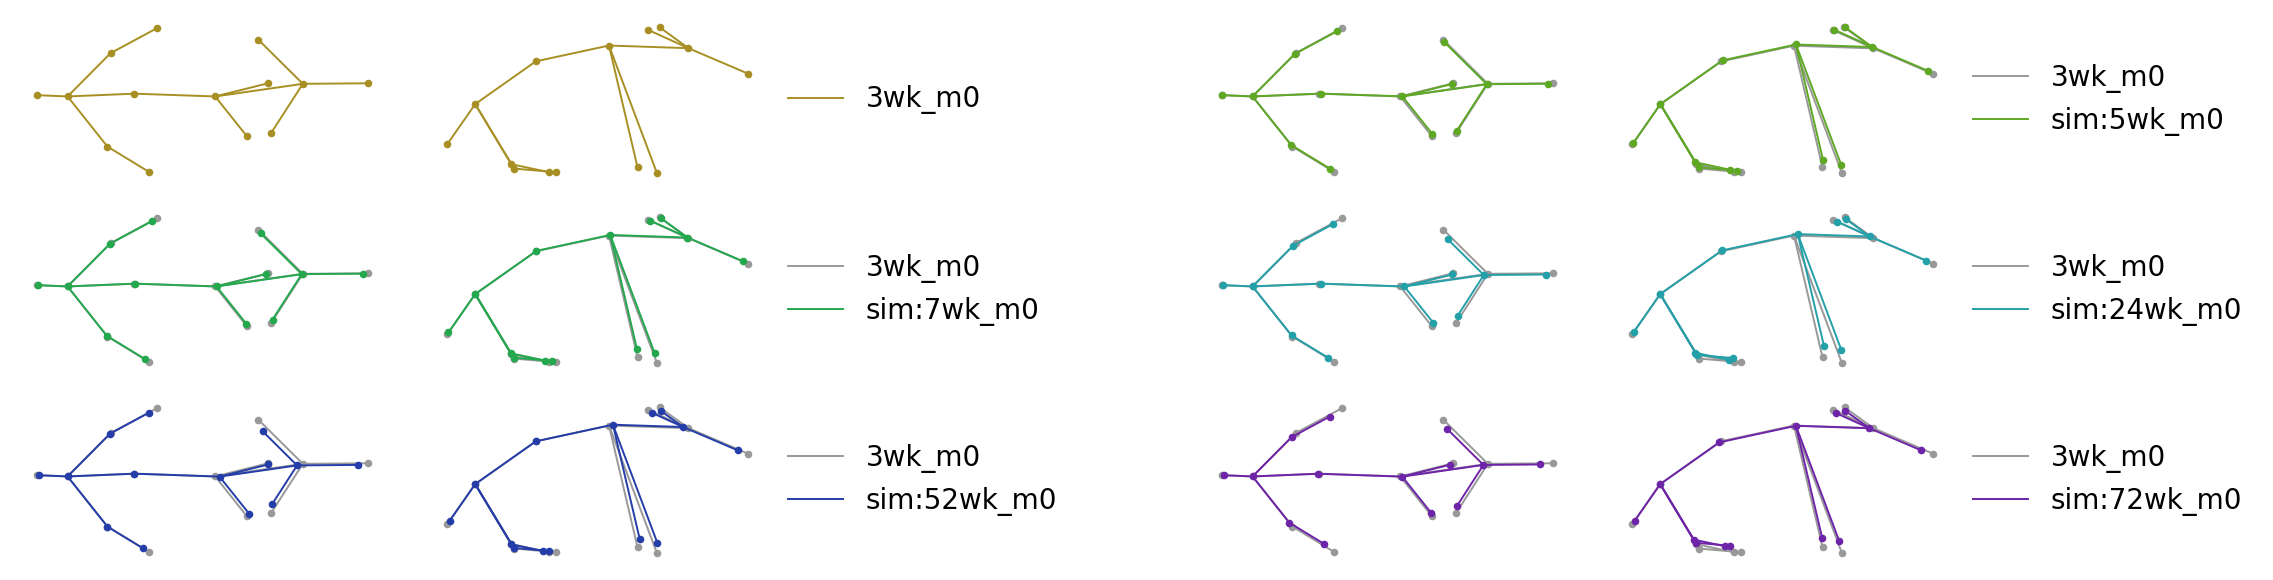

In [52]:
frame = 2250
src_sess = '3wk_m0'
meta = remap_metadata[src_sess]

tgt_ages, tgt_age_groups = keypt_io.get_groups_dict(meta['tgt_age'])

fig, ax = viz.struct.flat_grid(
    total = len(meta['tgt_age']) * 3,
    n_col = 2 * 3, ax_size = (2, 1),
    subplot_kw = dict(width_ratios = [1, 1, 1] * 2),)
axes = ax.reshape([-1, 3])

for i_tgt_age, (tgt_age, tgt_age_group) in enumerate(zip(tgt_ages, tgt_age_groups)):
    tgt_sess = tgt_age_group[0]
    tgt_slc = meta['session_slice'][tgt_sess]
    src_slc = meta['session_slice'][src_sess]
    for a, xaxis, yaxis in [
            (axes[i_tgt_age, 0], 0, 1),
            (axes[i_tgt_age, 1], 0, 2)]:
        if tgt_sess != src_sess:
            viz.diagram_plots.plot_mouse(
                a,
                remap_obs[src_sess].keypts[src_slc][frame].reshape([14, 3]),
                xaxis, yaxis,
                scatter_kw = {'color': '.6'},
                line_kw = {'color': '.6', 'lw': 0.7},
                zorder = 0,
                label = src_sess)
        simlabel = "sim:" if src_sess != tgt_sess else ""
        viz.diagram_plots.plot_mouse(
            a,
            remap_obs[src_sess].keypts[tgt_slc][frame].reshape([14, 3]),
            xaxis, yaxis,
            scatter_kw = {'color': age_pal[tgt_age]},
            line_kw = {'color': age_pal[tgt_age], 'lw': 0.7},
            zorder = 5,
            label = f'{simlabel}{tgt_sess}')
        a.set_axis_off()
    axes[i_tgt_age, 2].set_visible(False)

fig.tight_layout()
for i_tgt_age in range(len(tgt_ages)):
    axes[i_tgt_age, 1].legend(
        loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False,)
sns.despine()
plt.savefig(f"{plot_dir}/scaled-example-pose.png", dpi = 300)
plt.show()

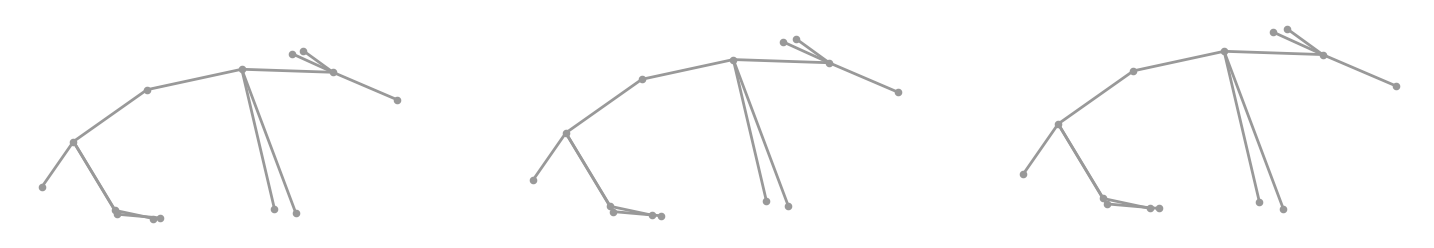

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (9, 3), sharex = True, sharey = True)

frame = 2250
clr = '.6' # age_pal[3]
slc = meta['session_slice']['72wk_m0']
viz.diagram_plots.plot_mouse(
    ax[0],
    remap_obs[src_sess].keypts[slc][frame].reshape([14, 3]),
    xaxis, yaxis,
    scatter_kw = {'color': clr},
    line_kw = {'color': clr, 'lw': 1})

clr = '.6' #age_pal[7]
slc = meta['session_slice']['7wk_m0']
viz.diagram_plots.plot_mouse(
    ax[1],
    remap_obs[src_sess].keypts[slc][frame].reshape([14, 3]),
    xaxis, yaxis,
    scatter_kw = {'color': clr},
    line_kw = {'color': clr, 'lw': 1})

clr = '.6' #age_pal[52]
slc = meta['session_slice']['3wk_m0']
viz.diagram_plots.plot_mouse(
    ax[2],
    remap_obs[src_sess].keypts[slc][frame].reshape([14, 3]),
    xaxis, yaxis,
    scatter_kw = {'color': clr},
    line_kw = {'color': clr, 'lw': 1})

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.savefig(f"{plot_dir}/three-grey-mice.pdf")